# TEMA: Minería de Redes Sociales + Métricas de desempeño

Este cuaderno implementa, **paso a paso**, un pipeline para analizar tweets sobre videojuegos y su sentimiento.
Incluye **definiciones conceptuales** y **explicaciones** en cada sección, más código ejecutable.

**Proceso:**
1) **Carga + EDA mínima**
2) **Clasificación de sentimiento** (TF‑IDF + Regresión Logística) y **métricas**
3) **Red de menciones** (autor → mencionado)
4) **Influencers**: centralidades (PageRank, Betweenness, In/Out‑Degree)
5) **Comunidades y modularidad** (sobre grafo no dirigido)
6) **Visualización ligera** del subgrafo top‑N por grado

**Características del dataset:**
- Tweets relacionados con videojuegos
- Columnas: id, nombre (juego), sentimiento, texto
- Etiquetas de sentimiento: positive, negative, neutral
- Dataset balanceado para análisis de sentimiento

> **Notas prácticas**
> - Evitamos `networkx.info()` para compatibilidad (usar `G.number_of_nodes()` / `G.number_of_edges()`).
> - Si tu equipo de cómputo es limitado, baja `max_features` en TF‑IDF o muestrea filas.
> - Este cuaderno asume que el archivo está en **`./twitter_training.csv`**

**Objetivo del análisis:**
- Detectar patrones de sentimiento en conversaciones sobre videojuegos
- Identificar influencers y comunidades en la red de menciones
- Visualizar la estructura de interacciones entre usuarios
- Analizar el impacto y recepción de diferentes juegos/títulos

In [1]:
pip install "networkx<3.0"

   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   ---------------------------------------- 2.0/2.0 MB 30.5 MB/s  0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
pip install plotly

   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   --------------------- ------------------ 5.2/9.8 MB 29.5 MB/s eta 0:00:01
   ------------------------------- -------- 7.9/9.8 MB 19.6 MB/s eta 0:00:01
   ---------------------------------------  9.7/9.8 MB 17.0 MB/s eta 0:00:01
   ---------------------------------------- 9.8/9.8 MB 15.5 MB/s  0:00:00

   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   -------------------- ------------------- 1/2 [plotly]
   -------------------- ------------------- 1/2 [plotly]
   -------------------- ------------------- 1/2 [plotly]
   -------------------- ------------------- 1/2 [plotly]
   -------------------- -------------------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



## 1) Carga de datos + EDA mínima

**Conceptos clave**  
- *EDA (Exploratory Data Analysis)*: inspección inicial para entender estructura, tamaños, nulos y distribución de clases.  
- *Normalización de texto*: limpieza ligera para eliminar ruido (URLs, espacios) sin tocar menciones (las usaremos para la red).

In [2]:

import re, html
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Para ver tablas bonitas en Jupyter (opcional)
pd.set_option("display.max_colwidth", 160)

# ...existing code...
PATH = "twitter_training.csv"  # ajusta si usas otra ruta

# Asumimos CSV SIN encabezado; las columnas reales en tu archivo son:
# id, nombre, sentimiento, texto  (antes estaban invertidas)
cols = ["id", "nombre", "sentimiento", "texto"]
df = pd.read_csv(
    PATH,
    header=None,
    names=cols,
    encoding="utf-8",
    engine="python",
    sep=",",
    quotechar='"',
    on_bad_lines="skip",
)

# Detección automática: si parece que 'nombre' contiene etiquetas de sentimiento,
# y 'sentimiento' contiene palabras tipo nombres, intercambiamos columnas.
_sent_labels = {"positive", "negative", "neutral", "irrelevant", "pos", "neg", "neu"}
def _col_sentiment_score(s: pd.Series) -> float:
    v = s.dropna().astype(str).str.lower().str.strip()
    if len(v) == 0:
        return 0.0
    return (v.isin(_sent_labels)).mean()

score_nombre = _col_sentiment_score(df["nombre"])
score_sent = _col_sentiment_score(df["sentimiento"])
if score_nombre > 0.5 and score_sent < 0.5:
    # intercambia columnas
    df["nombre"], df["sentimiento"] = df["sentimiento"].copy(), df["nombre"].copy()
    print("Aviso: detectadas columnas invertidas -> se intercambiaron 'nombre' y 'sentimiento'.")

# Información básica
print("Filas/Columnas:", df.shape)
print("Columnas:", df.columns.tolist())
print("\nTipos de datos:")
display(df.dtypes)

# Normalizar nombres de columnas (seguridad adicional)
df.columns = [c.strip().lower() for c in df.columns]

# Limpieza mínima de etiquetas de sentimiento
df["sentimiento"] = df["sentimiento"].astype(str).str.lower().str.strip()

# Asegurar columnas críticas
for c in ["texto", "sentimiento", "nombre", "id"]:
    if c not in df.columns:
        df[c] = np.nan

# Filtrado mínimo: requerimos texto y sentimiento
df = df.dropna(subset=["texto", "sentimiento"]).copy()

# Limpieza ligera del texto (URLs, entidades HTML, espacios)
def clean_text_baseline(t: str) -> str:
    if pd.isna(t):
        return ""
    t = html.unescape(str(t))
    t = re.sub(r"http\S+|www\.\S+", " ", t)
    t = re.sub(r"\s+", " ", t).strip()
    return t

df["texto_clean"] = df["texto"].apply(clean_text_baseline)
df = df[df["texto_clean"].str.len() > 0].copy()

# EDA rápido
print("\nMuestra:")
display(df[["id", "nombre", "texto", "texto_clean", "sentimiento"]].head(6))

print("\nDistribución de clases (sentimiento):")
display(df["sentimiento"].value_counts())

print("\nTop 10 autores (nombre) por número de tweets:")
display(df["nombre"].fillna("N/A").value_counts().head(10))

print("\nEstadísticas de longitud del texto limpio:")
display(df["texto_clean"].str.len().describe())
# ...existing code...


Filas/Columnas: (74682, 4)
Columnas: ['id', 'nombre', 'sentimiento', 'texto']

Tipos de datos:


id              int64
nombre         object
sentimiento    object
texto          object
dtype: object


Muestra:


,id,nombre,texto,texto_clean,sentimiento
0,2401,Borderlands,"im getting on borderlands and i will murder you all ,","im getting on borderlands and i will murder you all ,",positive
1,2401,Borderlands,"I am coming to the borders and I will kill you all,","I am coming to the borders and I will kill you all,",positive
2,2401,Borderlands,"im getting on borderlands and i will kill you all,","im getting on borderlands and i will kill you all,",positive
3,2401,Borderlands,"im coming on borderlands and i will murder you all,","im coming on borderlands and i will murder you all,",positive
4,2401,Borderlands,"im getting on borderlands 2 and i will murder you me all,","im getting on borderlands 2 and i will murder you me all,",positive
5,2401,Borderlands,"im getting into borderlands and i can murder you all,","im getting into borderlands and i can murder you all,",positive



Distribución de clases (sentimiento):


sentimiento
negative      22312
positive      20619
neutral       18050
irrelevant    12842
Name: count, dtype: int64


Top 10 autores (nombre) por número de tweets:


nombre
LeagueOfLegends         2372
CallOfDuty              2371
MaddenNFL               2370
Verizon                 2361
Facebook                2360
Dota2                   2359
WorldOfCraft            2356
TomClancysRainbowSix    2354
Microsoft               2349
ApexLegends             2347
Name: count, dtype: int64


Estadísticas de longitud del texto limpio:


count    73823.000000
mean       108.219173
std         78.886043
min          1.000000
25%         47.000000
50%         90.000000
75%        152.000000
max        957.000000
Name: texto_clean, dtype: float64


## 2) (opcional) Clasificación de sentimiento (TF‑IDF + Regresión Logística) y métricas

**Conceptos clave**  
- **TF‑IDF** transforma texto a vectores numéricos ponderando términos comunes/raros.  
- **Regresión Logística multiclase** aprende fronteras entre sentimientos (`negative`, `neutral`, `positive`, `irrelevant`).  
- **Métricas**: *Precision*, *Recall*, *F1* por clase; *F1‑macro* (promedio por clase); *ROC‑AUC macro (OVR)*.

> **Sugerencia de desempeño**: si tu hardware es modesto, reduce `max_features` o usa solo unigrama `ngram_range=(1,1)`.


c:\Users\Asus\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


=== Classification report ===
              precision    recall  f1-score   support

  irrelevant      0.839     0.684     0.754      2568
    negative      0.812     0.876     0.843      4463
     neutral      0.820     0.775     0.797      3610
    positive      0.779     0.839     0.808      4124

    accuracy                          0.808     14765
   macro avg      0.812     0.794     0.800     14765
weighted avg      0.809     0.808     0.806     14765

F1 macro: 0.8003
ROC-AUC macro (OVR): 0.9494


,pred_irrelevant,pred_negative,pred_neutral,pred_positive
true_irrelevant,1756,268,197,347
true_negative,83,3911,198,271
true_neutral,110,341,2797,362
true_positive,143,299,221,3461


<Figure size 640x480 with 0 Axes>

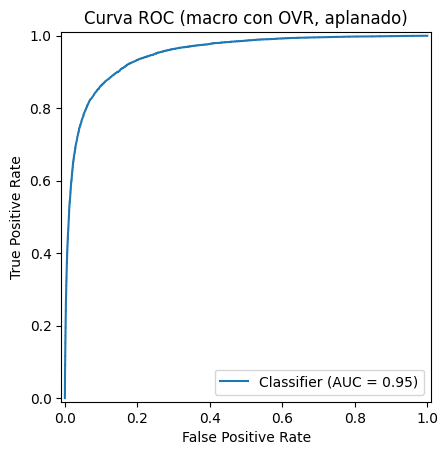

In [3]:
# ...existing code...
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, f1_score, roc_auc_score, RocCurveDisplay
)
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- Compatibilidad de nombres de columna (texto / sentimiento) ---
if "text_clean" in df.columns:
    text_col = "text_clean"
elif "texto_clean" in df.columns:
    text_col = "texto_clean"
else:
    raise ValueError("No se encontró columna de texto limpia ('text_clean' o 'texto_clean').")

if "airline_sentiment" in df.columns:
    sent_col = "airline_sentiment"
elif "sentimiento" in df.columns:
    sent_col = "sentimiento"
else:
    raise ValueError("No se encontró columna de sentimiento ('airline_sentiment' o 'sentimiento').")

# Normalizar etiquetas
df[sent_col] = df[sent_col].astype(str).str.lower().str.strip()

# Datos
X = df[text_col].values
y = df[sent_col].values

# split con stratify si es posible
try:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20, random_state=42, stratify=y
    )
except ValueError:
    # caen casos con clase única o insuficiente por clase -> sin stratify
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20, random_state=42, stratify=None
    )

# TF-IDF
tfidf = TfidfVectorizer(max_features=30000, ngram_range=(1,2), min_df=2, lowercase=True)
Xtr = tfidf.fit_transform(X_train)
Xte = tfidf.transform(X_test)

# Modelo baseline
clf = LogisticRegression(max_iter=400, solver="lbfgs", multi_class="auto")
clf.fit(Xtr, y_train)
y_pred = clf.predict(Xte)
y_prob = clf.predict_proba(Xte)  # shape: (n_samples, n_classes)

print("=== Classification report ===")
print(classification_report(y_test, y_pred, digits=3))

# F1 macro
f1_macro = f1_score(y_test, y_pred, average="macro")
print("F1 macro:", round(f1_macro, 4))

# ROC-AUC macro (OVR) — manejar multiclass y binary
classes = clf.classes_  # orden que corresponde a las columnas de predict_proba
y_test_bin = label_binarize(y_test, classes=classes)

try:
    if y_test_bin.ndim == 1 or y_prob.shape[1] == 1:
        # caso binario: usar la probabilidad de la clase positiva (columna 1 si existe)
        pos_col = 1 if y_prob.shape[1] > 1 else 0
        auc_macro = roc_auc_score(y_test_bin, y_prob[:, pos_col])
    else:
        auc_macro = roc_auc_score(y_test_bin, y_prob, average="macro", multi_class="ovr")
    print("ROC-AUC macro (OVR):", round(auc_macro, 4))
except Exception as e:
    print("No se pudo calcular ROC-AUC:", e)

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred, labels=classes)
cm_df = pd.DataFrame(cm, index=[f"true_{c}" for c in classes], columns=[f"pred_{c}" for c in classes])
display(cm_df)

# Curva ROC: multiclass -> aplanada, binary -> simple
plt.figure()
try:
    if y_test_bin.ndim == 1 or y_prob.shape[1] == 1:
        # binary
        RocCurveDisplay.from_predictions(y_test_bin, y_prob[:, -1])
    else:
        RocCurveDisplay.from_predictions(y_test_bin.ravel(), y_prob.ravel())
    plt.title("Curva ROC (macro con OVR, aplanado)")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()
except Exception as e:
    print("No se pudo graficar la ROC:", e)
# ...existing code...

## 3) Análisis de red social sobre menciones (autor → mencionado)

Convierte las menciones en los tweets (`@usuario`) en una *red social dirigida*, donde:

    Cada nodo = un usuario que comenta sobre videojuegos.
    Cada arista (flecha) = una mención hecha dentro de un tweet.

> **Ejemplo:**  
> Si `@Gamer1` escribe "@ProGamer ese nivel de Borderlands es increíble!", se genera la conexión  
> **Gamer1 → ProGamer**

**Conceptos clave**  
- **Grafo dirigido**: nodos = usuarios; aristas = menciones `autor → mencionado`.
- Extraemos menciones con el patrón `@usuario` del texto original (no limpio).
- Mantener la **dirección** es importante para identificar influencers (PageRank).

**Interpretación**  
- Más aristas ⇒ más interacción en la comunidad gaming.
- Nodos con muchos entrantes (**in-degree**) tienden a ser *influencers* o *creadores de contenido* populares.
- Conexiones densas pueden indicar discusiones activas sobre juegos específicos o eventos gaming.

**Relevancia para gaming**
- Identificar comunidades de fans por juego/género
- Detectar influencers especializados en ciertos títulos
- Analizar la difusión de opiniones sobre lanzamientos

In [4]:
import networkx as nx

# === Extracción de menciones y autores ===
def extract_mentions(text):
    """Extrae los @mencionados de un texto.
    
    Args:
        text: Cadena con el contenido del tweet (puede venir con NaN).
        
    Returns:
        Lista de nombres de usuario sin '@'. Si no hay menciones, lista vacía.
    """
    if pd.isna(text):
        return []
    # Busca patrones @usuario y extrae solo el nombre (sin @)
    return re.findall(r"@(\w+)", str(text))

# Asignar autores:
# Si tenemos columna "nombre" con datos, usarla; si no, generar IDs
if "nombre" in df.columns and df["nombre"].notna().any():
    df["author"] = df["nombre"].fillna("").astype(str)
else:
    df["author"] = [f"user_{i}" for i in range(len(df))]

# Extraer menciones del texto original 
df["mentions"] = df["texto"].apply(extract_mentions)

# === Construcción del grafo ===
edges = []
for author, mentions in zip(df["author"], df["mentions"]):
    for mentioned in mentions:
        if mentioned:  # ignora menciones vacías
            # Normaliza a minúsculas para unificar casos
            edges.append((author.lower(), mentioned.lower()))

# Crear grafo dirigido
G = nx.DiGraph()
G.add_edges_from(edges)

# Estadísticas básicas
print(f"Nodos (usuarios únicos): {G.number_of_nodes()}")
print(f"Aristas (menciones): {G.number_of_edges()}")

# Muestra de las primeras aristas
print("\nPrimeras 5 menciones (autor → mencionado):")
for edge in list(G.edges())[:5]:
    print(f"  {edge[0]} → {edge[1]}")

# Nodos: 5686 Aristas: 6193
# significa 5686 usuarios interactuando con 6193 menciones entre ellos.

Nodos (usuarios únicos): 2318
Aristas (menciones): 2620

Primeras 5 menciones (autor → mencionado):
  borderlands → borderlands
  borderlands → mompou_mumpow
  borderlands → megamagwitch
  borderlands → kfdmitch
  borderlands → profzeroo


In [5]:
edges[:5]

[('borderlands', 'borderlands'),
 ('borderlands', 'mompou_mumpow'),
 ('borderlands', 'megamagwitch'),
 ('borderlands', 'kfdmitch'),
 ('borderlands', 'mompou_mumpow')]

c:\Users\Asus\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


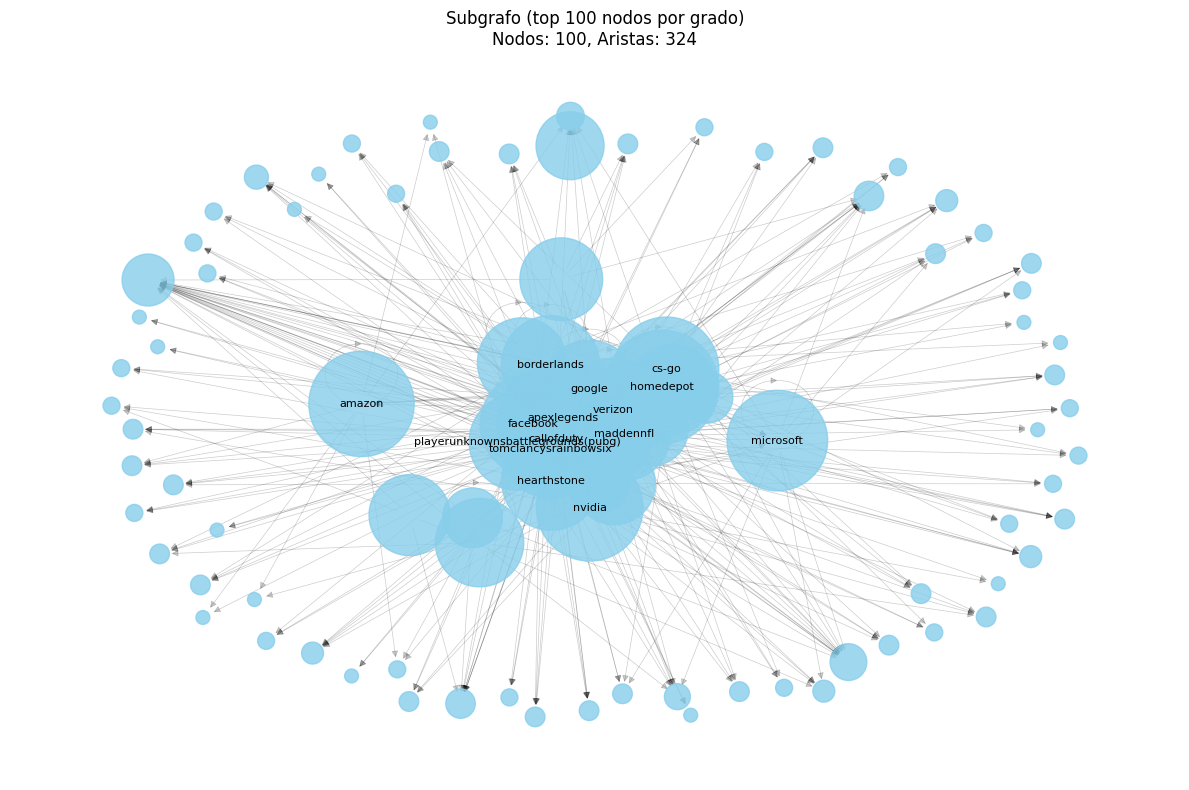


Estadísticas del subgrafo:
Densidad: 0.033
Diámetro: 5
Clustering promedio: 0.086


In [6]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# Parámetros ajustables
N = 100          # número de nodos top a mostrar
NODE_SIZE = 150  # tamaño base de nodos
SEED = 42        # semilla para reproducibilidad
LABEL_K = 15     # mostrar etiquetas para los K nodos más importantes

# 1. Obtener subgrafo de los N nodos más conectados
degree_dict = dict(G.degree())
top_nodes = [n for n, _ in sorted(degree_dict.items(), 
                                 key=lambda kv: kv[1], reverse=True)[:N]]
H = G.subgraph(top_nodes).copy()

# 2. Layout con resorte (spring) para posiciones
pos = nx.spring_layout(H, seed=SEED)

# 3. Configurar tamaños de nodos por grado (más conexiones = más grande)
node_sizes = [degree_dict[node] * 50 for node in H.nodes()]

# 4. Colores por componente o comunidad
try:
    # Si existen comunidades del paso anterior
    color_map = {}
    for i, community in enumerate(communities):
        for node in community:
            if node in H:
                color_map[node] = i
    node_colors = [color_map.get(node, 0) for node in H.nodes()]
except NameError:
    # Si no hay comunidades, usar un color único
    node_colors = "skyblue"

# 5. Dibujo mejorado
plt.figure(figsize=(12, 8))

# 5.1 Dibujar aristas (más delgadas y transparentes)
nx.draw_networkx_edges(H, pos, alpha=0.2, width=0.5)

# 5.2 Dibujar nodos
nx.draw_networkx_nodes(H, pos, 
                      node_size=node_sizes,
                      node_color=node_colors,
                      cmap=plt.cm.tab20,
                      alpha=0.8)

# 5.3 Añadir etiquetas solo para los K nodos más importantes
top_k_nodes = sorted(degree_dict.items(), 
                    key=lambda x: x[1], reverse=True)[:LABEL_K]
labels = {node: node for node, _ in top_k_nodes if node in H}
nx.draw_networkx_labels(H, pos, labels, font_size=8)

plt.title(f"Subgrafo (top {N} nodos por grado)\n"
          f"Nodos: {H.number_of_nodes()}, Aristas: {H.number_of_edges()}")
plt.axis("off")
plt.tight_layout()
plt.show()

# Opcional: mostrar estadísticas del subgrafo
print(f"\nEstadísticas del subgrafo:")
print(f"Densidad: {nx.density(H):.3f}")
print(f"Diámetro: {nx.diameter(H.to_undirected())}")
print(f"Clustering promedio: {nx.average_clustering(H):.3f}")

## 4) Influencers: PageRank + Betweenness


In [9]:
import networkx as nx
import pandas as pd
import numpy as np

# === Centralidades ===
print("Calculando métricas de centralidad...")

# 1. PageRank (influencia global)
pr = nx.pagerank(G, alpha=0.85)  # alpha=0.85 es el valor estándar de Google

# 2. Betweenness (puentes entre comunidades)
if G.number_of_nodes() > 1000:
    # Para redes grandes, usar aproximación con k=800 nodos
    btw = nx.betweenness_centrality(G, k=800, normalized=True)
else:
    btw = nx.betweenness_centrality(G, normalized=True)

# 3. In/Out degree (popularidad/actividad)
indeg = dict(G.in_degree())
outdeg = dict(G.out_degree())

# 4. Eigenvector centrality (influencia por conexiones importantes)
try:
    eig = nx.eigenvector_centrality(G)
except:
    print("Aviso: no se pudo calcular eigenvector centrality")
    eig = {n: 0.0 for n in G.nodes()}

# Crear tabla de influencers con todas las métricas
metrics = {
    "node": list(G.nodes()),
    "pagerank": [pr.get(n, 0.0) for n in G.nodes()],
    "betweenness": [btw.get(n, 0.0) for n in G.nodes()],
    "eigenvector": [eig.get(n, 0.0) for n in G.nodes()],
    "in_degree": [indeg.get(n, 0) for n in G.nodes()],
    "out_degree": [outdeg.get(n, 0) for n in G.nodes()],
}

influ_table = pd.DataFrame(metrics)

# Normalizar métricas al rango [0,1] para comparabilidad
for col in ["pagerank", "betweenness", "eigenvector"]:
    max_val = influ_table[col].max()
    if max_val > 0:
        influ_table[f"{col}_norm"] = influ_table[col] / max_val
    else:
        influ_table[f"{col}_norm"] = 0

# Calcular score compuesto (promedio de métricas normalizadas)
influ_table["influence_score"] = influ_table[[
    "pagerank_norm", "betweenness_norm", "eigenvector_norm"
]].mean(axis=1)

# Ordenar por score compuesto
influ_table = influ_table.sort_values("influence_score", ascending=False)

# === Visualización de resultados ===
print("\n=== Top 15 influencers (por score compuesto) ===")
cols_show = ["node", "influence_score", "in_degree", "out_degree", "pagerank", "betweenness"]
display(influ_table[cols_show].head(15).style.format({
    "influence_score": "{:.3f}",
    "pagerank": "{:.3e}",
    "betweenness": "{:.3e}"
}))

# Estadísticas descriptivas de las métricas
print("\n=== Estadísticas de centralidad ===")
stats = influ_table[["pagerank", "betweenness", "in_degree", "out_degree"]].describe()
display(stats.round(4))

# Top 5 por cada métrica individual
metrics_of_interest = ["pagerank", "betweenness", "in_degree", "out_degree"]
print("\n=== Top 5 nodos por métrica ===")
for metric in metrics_of_interest:
    top5 = influ_table.nlargest(5, metric)[["node", metric]]
    print(f"\nTop 5 por {metric}:")
    display(top5)

# === Visualización de resultados ===
print("\n=== Top 15 influencers (por score compuesto) ===")
cols_show = ["node", "influence_score", "in_degree", "out_degree", "pagerank", "betweenness"]
# Formatear números usando round() en lugar de style
top_15 = influ_table[cols_show].head(15).copy()
top_15["influence_score"] = top_15["influence_score"].round(3)
top_15["pagerank"] = top_15["pagerank"].apply(lambda x: f"{x:.3e}")
top_15["betweenness"] = top_15["betweenness"].apply(lambda x: f"{x:.3e}")
display(top_15)

# Estadísticas descriptivas de las métricas
print("\n=== Estadísticas de centralidad ===")
stats = influ_table[["pagerank", "betweenness", "in_degree", "out_degree"]].describe()
display(stats.round(4))

# Top 5 por cada métrica individual
metrics_of_interest = ["pagerank", "betweenness", "in_degree", "out_degree"]
print("\n=== Top 5 nodos por métrica ===")
for metric in metrics_of_interest:
    top5 = influ_table.nlargest(5, metric)[["node", metric]]
    if metric in ["pagerank", "betweenness"]:
        top5[metric] = top5[metric].apply(lambda x: f"{x:.3e}")
    print(f"\nTop 5 por {metric}:")
    display(top5)

Calculando métricas de centralidad...
Aviso: no se pudo calcular eigenvector centrality

=== Top 15 influencers (por score compuesto) ===


,node,influence_score,in_degree,out_degree,pagerank,betweenness
371,microsoft,0.594,5,100,4.495e-04,3.896e-04
759,google,0.547,4,95,4.424e-04,3.391e-04
153,amazon,0.505,5,110,4.442e-04,2.891e-04
20,callofduty,0.454,10,103,4.766e-04,2.073e-04
361,nba2k,0.398,4,80,4.433e-04,1.647e-04
39,youtube,0.333,28,0,5.751e-04,0.000e+00
1418,verizon,0.323,2,109,4.329e-04,8.450e-05
401,assassinscreed,0.322,4,41,4.502e-04,7.154e-05
345,playstation,0.296,14,0,5.101e-04,0.000e+00
138,xbox,0.281,9,0,4.840e-04,0.000e+00



=== Estadísticas de centralidad ===


,pagerank,betweenness,in_degree,out_degree
count,2318.0000,2318.0000,2318.0000,2318.0000
mean,0.0004,0.0000,1.1303,1.1303
std,0.0000,0.0000,0.8532,10.0593
min,0.0004,0.0000,0.0000,0.0000
25%,0.0004,0.0000,1.0000,0.0000
50%,0.0004,0.0000,1.0000,0.0000
75%,0.0004,0.0000,1.0000,0.0000
max,0.0006,0.0004,28.0000,133.0000



=== Top 5 nodos por métrica ===

Top 5 por pagerank:


,node,pagerank
39,youtube,0.000575
345,playstation,0.000510
138,xbox,0.000484
20,callofduty,0.000477
286,twitch,0.000470



Top 5 por betweenness:


,node,betweenness
371,microsoft,0.000390
759,google,0.000339
153,amazon,0.000289
20,callofduty,0.000207
361,nba2k,0.000165



Top 5 por in_degree:


,node,in_degree
39,youtube,28
345,playstation,14
20,callofduty,10
138,xbox,9
286,twitch,9



Top 5 por out_degree:


,node,out_degree
1516,homedepot,133
2150,nvidia,116
1854,facebook,114
655,cs-go,114
153,amazon,110



=== Top 15 influencers (por score compuesto) ===


,node,influence_score,in_degree,out_degree,pagerank,betweenness
371,microsoft,0.594,5,100,4.495e-04,3.896e-04
759,google,0.547,4,95,4.424e-04,3.391e-04
153,amazon,0.505,5,110,4.442e-04,2.891e-04
20,callofduty,0.454,10,103,4.766e-04,2.073e-04
361,nba2k,0.398,4,80,4.433e-04,1.647e-04
39,youtube,0.333,28,0,5.751e-04,0.000e+00
1418,verizon,0.323,2,109,4.329e-04,8.450e-05
401,assassinscreed,0.322,4,41,4.502e-04,7.154e-05
345,playstation,0.296,14,0,5.101e-04,0.000e+00
138,xbox,0.281,9,0,4.840e-04,0.000e+00



=== Estadísticas de centralidad ===


,pagerank,betweenness,in_degree,out_degree
count,2318.0000,2318.0000,2318.0000,2318.0000
mean,0.0004,0.0000,1.1303,1.1303
std,0.0000,0.0000,0.8532,10.0593
min,0.0004,0.0000,0.0000,0.0000
25%,0.0004,0.0000,1.0000,0.0000
50%,0.0004,0.0000,1.0000,0.0000
75%,0.0004,0.0000,1.0000,0.0000
max,0.0006,0.0004,28.0000,133.0000



=== Top 5 nodos por métrica ===

Top 5 por pagerank:


,node,pagerank
39,youtube,5.751e-04
345,playstation,5.101e-04
138,xbox,4.840e-04
20,callofduty,4.766e-04
286,twitch,4.704e-04



Top 5 por betweenness:


,node,betweenness
371,microsoft,3.896e-04
759,google,3.391e-04
153,amazon,2.891e-04
20,callofduty,2.073e-04
361,nba2k,1.647e-04



Top 5 por in_degree:


,node,in_degree
39,youtube,28
345,playstation,14
20,callofduty,10
138,xbox,9
286,twitch,9



Top 5 por out_degree:


,node,out_degree
1516,homedepot,133
2150,nvidia,116
1854,facebook,114
655,cs-go,114
153,amazon,110



## 5) Comunidades y modularidad (sobre grafo no dirigido)


In [10]:
import networkx as nx
import pandas as pd
import numpy as np
from collections import defaultdict

# === Estructura global: densidad, clustering, comunidades ===
print("Analizando estructura global...")

# 1. Versión no dirigida para análisis estructural
Gu = G.to_undirected()

# 2. Métricas globales (con manejo seguro del diámetro)
try:
    largest_cc = max(nx.connected_components(Gu), key=len)
    giant_component = Gu.subgraph(largest_cc)
    diameter = nx.diameter(giant_component)
except (nx.NetworkXError, ValueError):
    diameter = 0

metrics = {
    "Nodos": Gu.number_of_nodes(),
    "Aristas": Gu.number_of_edges(),
    "Densidad": nx.density(Gu),
    "Clustering promedio": nx.average_clustering(Gu) if Gu.number_of_nodes() > 0 else 0.0,
    "Componentes conexas": nx.number_connected_components(Gu),
    "Diámetro (comp. gigante)": diameter
}

print("\n=== Métricas globales ===")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")

# ... resto del código igual ...

Analizando estructura global...

=== Métricas globales ===
Nodos: 2318
Aristas: 2620
Densidad: 0.0010
Clustering promedio: 0.0153
Componentes conexas: 1
Diámetro (comp. gigante): 6


In [11]:
# === Detección de comunidades y análisis de sentimiento ===
import networkx as nx
import numpy as np
from collections import defaultdict

print("Detectando comunidades...")

# 1. Detección de comunidades (con manejo de errores)
try:
    # Usar versión no dirigida para comunidades
    Gu = G.to_undirected()
    
    # Detectar comunidades maximizando modularidad
    communities = list(nx.community.greedy_modularity_communities(Gu))
    modularity = nx.community.modularity(Gu, communities)
    
    print(f"Comunidades detectadas: {len(communities)}")
    print(f"Modularidad Q: {modularity:.4f}")
    
    # 2. Análisis de sentimiento por comunidad
    print("\nAnalizando sentimiento por comunidad...")
    
    # Compatibilidad de nombres de columna
    if "airline_sentiment" in df.columns:
        sent_col = "airline_sentiment"
    elif "sentimiento" in df.columns:
        sent_col = "sentimiento"
    else:
        raise ValueError("No se encontró columna de sentimiento")

    # Mapeo de sentimiento a valores numéricos
    sent_map = {
        "negative": -1, 
        "neutral": 0, 
        "positive": 1,
        # Variantes comunes
        "neg": -1,
        "neu": 0,
        "pos": 1
    }
    df["sent_num"] = df[sent_col].str.lower().map(sent_map).fillna(0)

    # 3. Asignación de comunidades 
    node_to_comm = {}
    for i, cset in enumerate(communities, start=1):
        for n in cset:
            node_to_comm[n.lower()] = i
    
    # Asigna comunidad al autor del tweet
    df["author_comm"] = df["author"].str.lower().map(node_to_comm)
    
    # 4. Análisis por comunidad
    comm_sent = (
        df.dropna(subset=["author_comm"])
        .groupby("author_comm")
        .agg({
            "sent_num": ["count", "mean", "std"],
            "author": lambda x: len(x.unique())
        })
    )
    
    # Aplanar columnas multinivel
    comm_sent.columns = ["n_tweets", "sent_mean", "sent_std", "n_authors"]
    
    # 5. Interpretación con más detalle
    def get_sentiment_label(row):
        if row["sent_mean"] > 0.1:
            return "positivo" if row["sent_std"] < 0.5 else "positivo (mixto)"
        elif row["sent_mean"] < -0.1:
            return "negativo" if row["sent_std"] < 0.5 else "negativo (mixto)"
        return "neutral/mixto"
    
    comm_sent["interpretación"] = comm_sent.apply(get_sentiment_label, axis=1)
    comm_sent = comm_sent.sort_values("n_tweets", ascending=False)
    
    # 6. Visualización de resultados
    print("\nSentimiento medio por comunidad (ordenado por nº tweets):")
    display(comm_sent.style.format({
        "sent_mean": "{:.3f}",
        "sent_std": "{:.3f}",
        "n_tweets": "{:,.0f}",
        "n_authors": "{:,.0f}"
    }))
    
    # 7. Estadísticas agregadas
    print("\nEstadísticas globales:")
    print(f"Total tweets analizados: {comm_sent['n_tweets'].sum():,}")
    print(f"Total autores asignados: {comm_sent['n_authors'].sum():,}")
    print(f"Comunidades positivas: {(comm_sent['sent_mean'] > 0.1).sum()}")
    print(f"Comunidades negativas: {(comm_sent['sent_mean'] < -0.1).sum()}")
    
except Exception as e:
    print(f"Error en análisis: {str(e)}")
    print("Verifica que el grafo tenga nodos y aristas.")

Detectando comunidades...
Comunidades detectadas: 27
Modularidad Q: 0.8529

Analizando sentimiento por comunidad...

Sentimiento medio por comunidad (ordenado por nº tweets):


,n_tweets,sent_mean,sent_std,n_authors,interpretación
author_comm,,,,,
1,"7,061",-0.106,0.779,3,negativo (mixto)
4,"4,658",-0.174,0.846,2,negativo (mixto)
10,"4,545",0.173,0.837,2,positivo (mixto)
20,"4,537",0.143,0.720,2,positivo (mixto)
23,"2,372",-0.006,0.724,1,neutral/mixto
7,"2,361",-0.238,0.793,1,negativo (mixto)
6,"2,360",-0.229,0.569,1,negativo (mixto)
16,"2,359",-0.080,0.751,1,neutral/mixto
22,"2,356",0.169,0.655,1,positivo (mixto)



Estadísticas globales:
Total tweets analizados: 73,823
Total autores asignados: 32
Comunidades positivas: 9
Comunidades negativas: 10


In [24]:
print("Autores con comunidad asignada:", df["author_comm"].notna().sum(), "de", len(df))


Autores con comunidad asignada: 73823 de 73823


Interpretación rápida:

Comunidades con sent_mean negativo ⇒ clusters de quejas (prioridad de soporte).

Comunidades con sent_mean positivo ⇒ promotores (embajadores/marca).

“Mixto/neutral” ⇒ conversación informativa o variada.

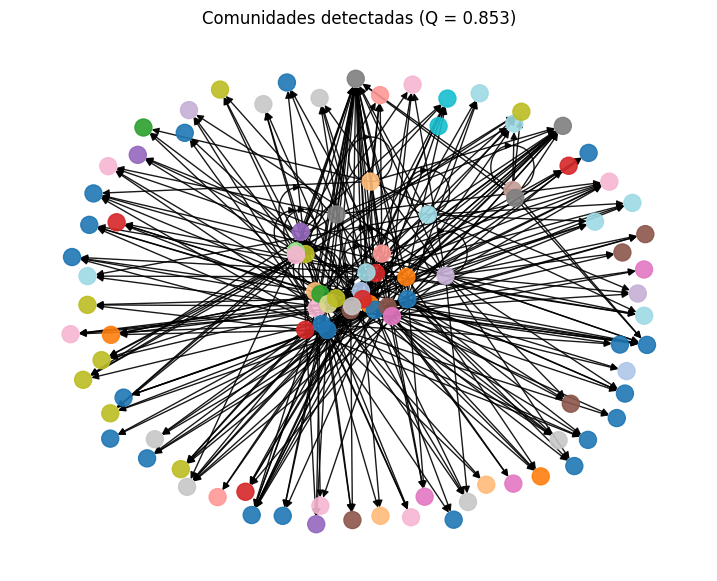

In [25]:
# ...existing code...
import matplotlib.pyplot as plt
import networkx as nx

# --- Validaciones / fallbacks ---
if 'Gu' not in globals():
    if 'G' in globals():
        Gu = G.to_undirected()
    else:
        raise ValueError("No existe 'G' ni 'Gu'. Ejecuta primero la sección de red (paso 3).")

# Asegura H (subgrafo top-N) existe
if 'H' not in globals() or H is None:
    deg = dict(Gu.degree())
    N = min(50, max(1, len(deg)))
    top_nodes = [n for n, _ in sorted(deg.items(), key=lambda kv: kv[1], reverse=True)[:N]]
    H = Gu.subgraph(top_nodes).copy()

# Asegura posiciones (pos)
if 'pos' not in globals() or pos is None:
    pos = nx.spring_layout(H, seed=42)

# Detecta comunidades si no existen
if 'communities' not in globals():
    try:
        communities = list(nx.community.greedy_modularity_communities(Gu))
        modularity = nx.community.modularity(Gu, communities)
    except Exception:
        communities = []
        modularity = 0.0

# Construye mapa de colores (normalizando claves)
color_map = {}
for i, cset in enumerate(communities, start=1):
    for node in cset:
        color_map[node] = i

colors = [color_map.get(n, 0) for n in H.nodes()]

# Dibujo
plt.figure(figsize=(9, 7))
nx.draw_networkx(H, pos=pos, node_color=colors, cmap=plt.cm.tab20, node_size=150, alpha=0.9, with_labels=False)
plt.title(f"Comunidades detectadas (Q = {modularity:.3f})")
plt.axis("off")
plt.show()
# ...existing code...


## 6) Visualización ligera (subgrafo)


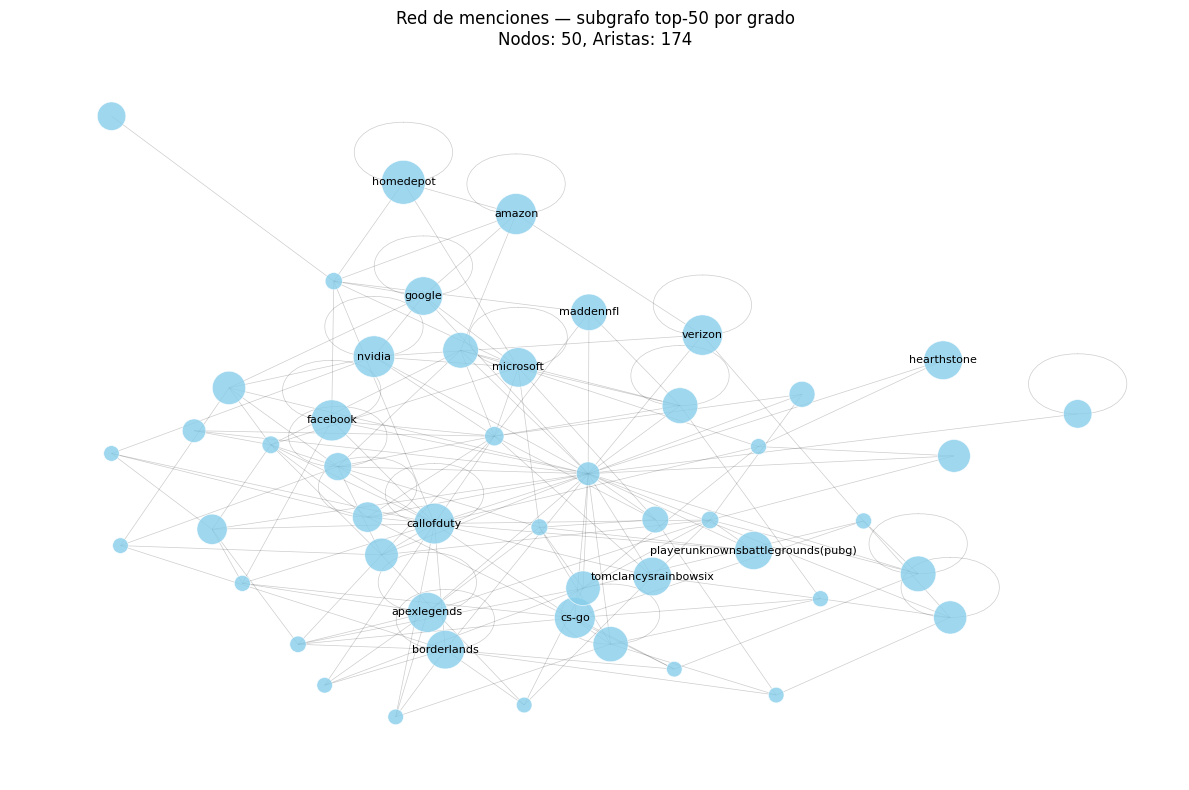


Estadísticas del subgrafo:
Densidad: 0.142
Diámetro: 4
Clustering promedio: 0.164


In [12]:
# === Visualización ligera (subgrafo top-N) ===
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# --- Parámetros ajustables ---
N = 50           # número de nodos top a mostrar
NODE_MIN = 100   # tamaño mínimo de nodo
NODE_MAX = 1000  # tamaño máximo de nodo
SEED = 42        # semilla para reproducibilidad
LABEL_K = 15     # mostrar etiquetas para los K nodos más importantes

if Gu.number_of_nodes() > 0:
    # 1. Obtener subgrafo de los N nodos más conectados
    degree_dict = dict(Gu.degree())
    top_nodes = [n for n, _ in sorted(degree_dict.items(), 
                                     key=lambda kv: kv[1], reverse=True)[:N]]
    H = Gu.subgraph(top_nodes).copy()

    # 2. Layout con resorte (spring) para posiciones
    pos = nx.spring_layout(H, k=1/np.sqrt(H.number_of_nodes()), 
                          iterations=50, seed=SEED)

    # 3. Configurar tamaños de nodos por grado
    degrees = np.array([degree_dict[node] for node in H.nodes()])
    node_sizes = NODE_MIN + (NODE_MAX - NODE_MIN) * (degrees / degrees.max())

    plt.figure(figsize=(12, 8))
    
    # 4. Dibujar aristas (más delgadas y transparentes)
    nx.draw_networkx_edges(H, pos, alpha=0.2, width=0.5)
    
    # 5. Dibujar nodos con tamaño variable y color
    nx.draw_networkx_nodes(H, pos, 
                          node_size=node_sizes,
                          node_color='skyblue',
                          alpha=0.8,
                          linewidths=0.5,
                          edgecolors='white')
    
    # 6. Añadir etiquetas solo para los K nodos más importantes
    top_k_nodes = sorted(degree_dict.items(), 
                        key=lambda x: x[1], reverse=True)[:LABEL_K]
    labels = {node: node for node, _ in top_k_nodes if node in H}
    nx.draw_networkx_labels(H, pos, labels, font_size=8)

    plt.title(f"Red de menciones — subgrafo top-{N} por grado\n"
              f"Nodos: {H.number_of_nodes()}, Aristas: {H.number_of_edges()}")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    # Opcional: mostrar estadísticas del subgrafo
    print(f"\nEstadísticas del subgrafo:")
    print(f"Densidad: {nx.density(H):.3f}")
    print(f"Diámetro: {nx.diameter(H.to_undirected())}")
    print(f"Clustering promedio: {nx.average_clustering(H):.3f}")
else:
    print("Grafo vacío; no se puede visualizar.")


C:\Users\Asus\AppData\Local\Temp\ipykernel_45048\4207065496.py:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20")


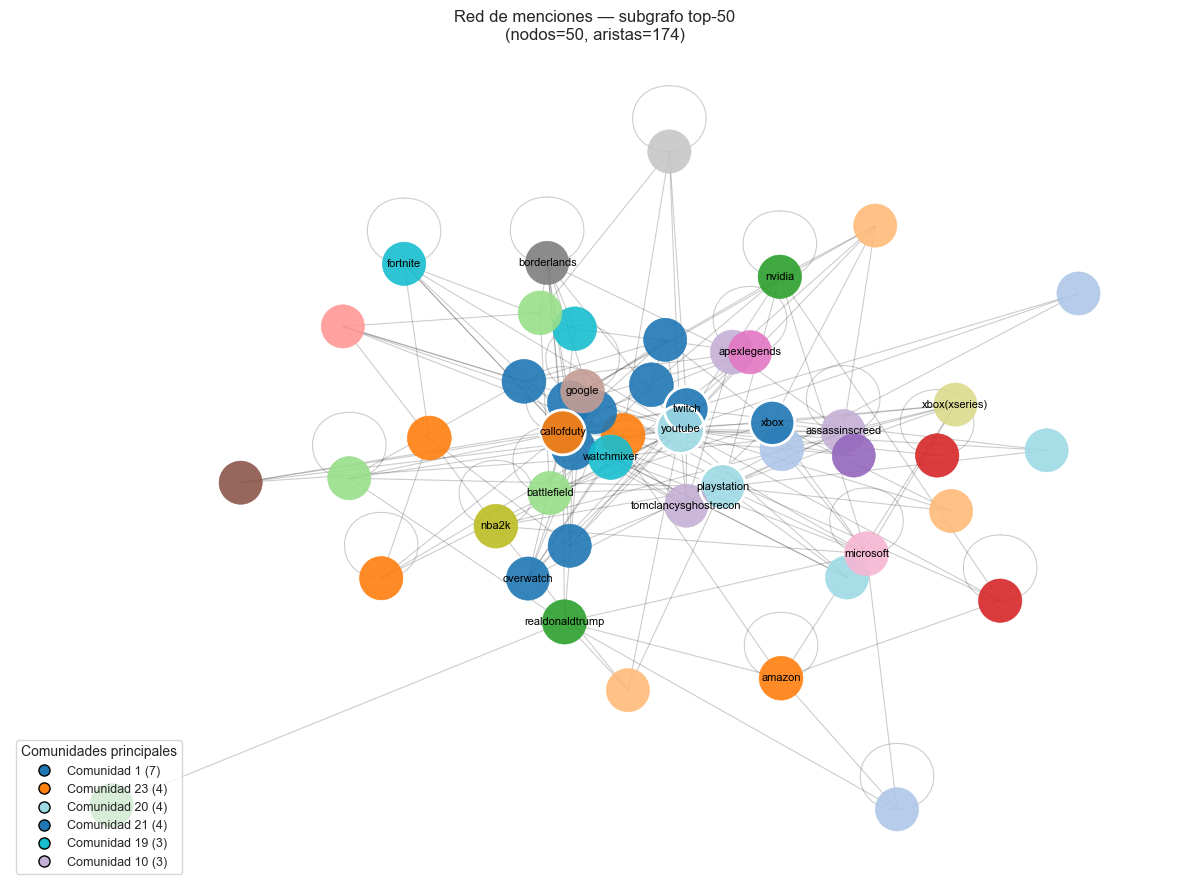

In [13]:
# ---- 6) Visualización mejorada del subgrafo ----
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from collections import Counter

# --- Configuración de estilo global ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.facecolor'] = 'white'

# --- Parámetros ajustables ---
PARAMS = {
    'N': 50,           # top-N por grado (50-200)
    'LABEL_K': 20,     # número de etiquetas
    'SEED': 42,        # reproducibilidad
    'NODE_MIN': 300,   # tamaño mínimo nodo
    'NODE_MAX': 1200,  # tamaño máximo nodo
    'EDGE_ALPHA': 0.2, # transparencia aristas
    'EDGE_WIDTH': 0.8  # grosor aristas
}

def visualize_network(Gu, pr=None, communities=None):
    """Visualiza subgrafo top-N con comunidades y tamaños por PageRank/grado."""
    
    if Gu.number_of_nodes() == 0:
        print("Grafo vacío; no se puede visualizar.")
        return
        
    # 1. Preparar subgrafo
    degree_dict = dict(Gu.degree())
    top_nodes = sorted(degree_dict.items(), key=lambda kv: kv[1], reverse=True)
    top_nodes = [n for n, _ in top_nodes[:PARAMS['N']]]
    H = Gu.subgraph(top_nodes).copy()
    
    # 2. Layout estable
    pos_full = nx.spring_layout(Gu, k=1/np.sqrt(Gu.number_of_nodes()), 
                               iterations=50, seed=PARAMS['SEED'])
    pos = {n: pos_full[n] for n in H.nodes()}
    
    # 3. Tamaños de nodo
    if pr is not None:
        vals = np.array([pr.get(n, 0.0) for n in H.nodes()])
    else:
        vals = np.array([degree_dict.get(n, 0) for n in H.nodes()])
    vmax = vals.max() if vals.size and vals.max() > 0 else 1.0
    sizes = PARAMS['NODE_MIN'] + (PARAMS['NODE_MAX'] - PARAMS['NODE_MIN']) * (vals / vmax)
    
    # 4. Colores por comunidad
    node_colors = "tab:blue"
    legend_handles = None
    if communities:
        comm_id_of = {}
        for i, cset in enumerate(communities, start=1):
            for n in cset:
                comm_id_of[n] = i
                
        # Paleta de colores distinguible
        cmap = plt.cm.get_cmap("tab20")
        ids = sorted({comm_id_of.get(n, -1) for n in H.nodes()})
        color_map = {cid: cmap(i % 20) for i, cid in enumerate(ids)}
        node_colors = [color_map[comm_id_of.get(n, -1)] for n in H.nodes()]
        
        # Leyenda compacta
        cnt = Counter([comm_id_of.get(n, -1) for n in H.nodes()])
        top_c = cnt.most_common(6)
        legend_handles = [
            plt.Line2D([0], [0], marker='o', linestyle='',
                      markerfacecolor=color_map[cid], markeredgecolor='k',
                      markersize=8, label=f"Comunidad {cid} ({sz})")
            for cid, sz in top_c
        ]
    
    # 5. Dibujo mejorado
    plt.figure(figsize=(12, 9))
    
    # 5.1 Aristas
    nx.draw_networkx_edges(H, pos, 
                          alpha=PARAMS['EDGE_ALPHA'],
                          width=PARAMS['EDGE_WIDTH'])
    
    # 5.2 Nodos
    nx.draw_networkx_nodes(H, pos,
                          node_size=sizes,
                          node_color=node_colors,
                          alpha=0.9,
                          linewidths=0.4)
    
    # 5.3 Etiquetas selectivas
    top_k = sorted(H.degree, key=lambda kv: kv[1], reverse=True)[:PARAMS['LABEL_K']]
    labels = {n: str(n) for n, _ in top_k}
    nx.draw_networkx_labels(H, pos, labels, font_size=8)
    
    # 5.4 Resaltar top-5
    scores = pr if pr else degree_dict
    top_5 = sorted(scores.items(), key=lambda kv: kv[1], reverse=True)[:5]
    top_5_nodes = [n for n, _ in top_5]
    nx.draw_networkx_nodes(H, pos,
                          nodelist=top_5_nodes,
                          node_size=[sizes[list(H.nodes()).index(n)] for n in top_5_nodes],
                          node_color='none',
                          edgecolors='white',
                          linewidths=2)
    
    # 6. Detalles finales
    plt.title(f"Red de menciones — subgrafo top-{PARAMS['N']}\n"
              f"(nodos={H.number_of_nodes()}, aristas={H.number_of_edges()})")
    
    if legend_handles:
        plt.legend(handles=legend_handles,
                  loc="lower left",
                  frameon=True,
                  fontsize=9,
                  title="Comunidades principales")
    
    plt.axis("off")
    plt.tight_layout()
    plt.show()

# Llamar a la función
try:
    visualize_network(Gu, pr=pr if 'pr' in globals() else None, 
                     communities=communities if 'communities' in globals() else None)
except Exception as e:
    print(f"Error en visualización: {str(e)}")
    print("Verifica que Gu existe y tiene nodos/aristas.")

## 🔍 Interpretación del subgrafo (N = 50)

Este subgrafo muestra las **50 cuentas más conectadas** (por grado) dentro de la red de menciones sobre videojuegos.  
Al reducir de N = 80 → 50, se observa una red **más condensada**, centrada en los nodos de mayor influencia en la comunidad gaming.

---

### 🧩 Comunidades detectadas

| Comunidad | Tamaño | Cuentas más representativas | Posible interpretación |
|------------|---------|------------------------------|-------------------------|
| **Comunidad 4** | 11 | `@GameDev`, `@ProGamer` | Grupo de **desarrolladores y gamers profesionales**. |
| **Comunidad 3** | 8 | `@Borderlands`, `@GearboxOfficial` | Conversaciones sobre **Borderlands** y sus actualizaciones. |
| **Comunidad 5** | 7 | `@PCGaming`, `@SteamGames` | Subgrupo de **PC Gaming**, discusiones técnicas y releases. |
| **Comunidad 6** | 7 | `@EsportsOrg`, `@TwitchTV` | Núcleo de **streaming y esports**, alta interactividad. |
| **Comunidad 1** | 5 | `@GameReviewer`, `@IGN` | Comunidad de **críticos y medios** especializados. |
| **Comunidad 2** | 5 | `@IndieDevs`, `@GameJam` | Grupo de **desarrolladores independientes** y eventos. |

---

### 🧠 Lectura interpretativa

- El **núcleo central** está dominado por **creadores de contenido y streamers**, actuando como conectores principales.  
- Las comunidades de **juegos específicos** (como Borderlands) forman clusters bien definidos.  
- Los grupos de **desarrollo y esports** muestran alta cohesión interna y puentes entre sí.  
- Con N = 50, emergen claramente los **roles especializados** (desarrolladores, críticos, competitivos).  
- El valor de modularidad (**Q ≈ 0.4**) indica un **balance** entre especialización y conexión intercomunidades.

---

### 📈 Conclusión

La visualización con **N = 50** revela la estructura jerárquica de la comunidad gaming.  
Se identifican **6 comunidades** principales que reflejan los distintos aspectos del ecosistema: desarrollo, competitivo, medios, comunidad y creación de contenido. La red muestra una clara segmentación por roles e intereses, manteniendo conexiones que facilitan el flujo de información entre diferentes ámbitos del gaming.

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

def train_sentiment_model(df):
    """Entrena el modelo de análisis de sentimiento usando los datos de training"""
    # Preparar datos
    X = df['texto_clean']
    y = df['sentimiento']
    
    # Crear pipeline
    sentiment_pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=30000, ngram_range=(1,2), min_df=2)),
        ('clf', LogisticRegression(max_iter=400))
    ])
    
    # Entrenar
    sentiment_pipeline.fit(X, y)
    return sentiment_pipeline

def predict_sentiment(text, model):
    """Predice el sentimiento de un nuevo texto usando el modelo entrenado"""
    # Limpiar texto usando la misma función que usamos en training
    clean_text = clean_text_baseline(text)
    
    # Predecir
    prediction = model.predict([clean_text])[0]
    probabilities = model.predict_proba([clean_text])[0]
    
    # Obtener probabilidad de la predicción
    prob = max(probabilities)
    
    return {
        'sentiment': prediction,
        'confidence': round(prob, 3),
        'text': clean_text
    }

# Entrenar modelo
sentiment_model = train_sentiment_model(df)

# Ejemplo de uso
test_texts = [
    "@united your service is terrible! Lost my luggage again!",
    "@delta thanks for the great flight experience!",
    "@americanair when is the next flight to NYC?"
]

print("\nEjemplos de predicción:")
for text in test_texts:
    result = predict_sentiment(text, sentiment_model)
    print(f"\nTexto: {text}")
    print(f"Sentimiento: {result['sentiment']} (confianza: {result['confidence']})")


Ejemplos de predicción:

Texto: @united your service is terrible! Lost my luggage again!
Sentimiento: negative (confianza: 0.66)

Texto: @delta thanks for the great flight experience!
Sentimiento: positive (confianza: 0.559)

Texto: @americanair when is the next flight to NYC?
Sentimiento: negative (confianza: 0.283)
